In [1]:
import json
import pandas as pd

### Loading Business data

In [2]:
biz_file = open("/Users/ktxdev/Documents/MS in AI/Data Acquisition & Management/Datasets/yelp/yelp_academic_dataset_business.json")
biz_df = pd.DataFrame([json.loads(x) for x in biz_file.readlines()])
biz_file.close()

### Loading the reviews file

In [3]:
reviews_file = open("/Users/ktxdev/Documents/MS in AI/Data Acquisition & Management/Datasets/yelp/yelp_academic_dataset_review.json")
reviews_df = pd.DataFrame([json.loads(x) for x in reviews_file.readlines()])
reviews_file.close()

### Putting out Nightlife and Restaurants only

In [4]:
two_biz = biz_df[biz_df['categories'].apply(lambda x: any(x is not None and cat in x for cat in ['Nightlife', 'Restaurants']))]

### Joining all the reviews for the two types of business

In [6]:
two_biz_reviews = two_biz.merge(reviews_df, on='business_id', how='inner')

### Select features

In [7]:
two_biz_reviews = two_biz_reviews[['business_id', 'name', 'stars_y', 'text', 'categories']]

### Create Target column with Nightlife as True

In [21]:
two_biz_reviews['target'] = two_biz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)

### Creating a balanced classification dataset

In [22]:
nightlife = two_biz_reviews[two_biz_reviews['target'] == True]
restaurants = two_biz_reviews[two_biz_reviews['target'] == False]

nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurants_subset = restaurants.sample(frac=0.021, random_state=123)

two_biz_reviews_subset = pd.concat([nightlife_subset, restaurants_subset])

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(two_biz_reviews_subset, train_size=0.7, random_state=123)

print(train_data.shape)
print(test_data.shape)


(157035, 6)
(67301, 6)


### Transform features

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transform = CountVectorizer()
X_tr_bow = bow_transform.fit_transform(train_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])

y_tr = train_data['target']
y_te = test_data['target']

### Create the tf-idf representation using the bag-of-words matrix

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(norm=None)

X_tr_tfidf = tfidf_transformer.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transformer.transform(X_te_bow)

# l2-normalize the bag-of-words representation
from sklearn.preprocessing import normalize

X_tr_l2 = normalize(X_tr_bow, axis=0)
X_te_l2 = normalize(X_te_bow, axis=0)

### Training logistic regression classifiers with default parameters

In [35]:
from sklearn.linear_model import LogisticRegression

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C = 1.0):
    m = LogisticRegression(max_iter=100000, C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print("Test score with", description, 'features:', s)
    return m

m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.7762588965988618
Test score with l2-normalized features: 0.7396026804950893
Test score with tf-idf features: 0.7431687493499354


### Tuning logistic regression hyperparameters with grid search

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

params = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

bow_search = GridSearchCV(LogisticRegression(max_iter=100000), cv=5, param_grid=params)
bow_search.fit(X_tr_bow, y_tr)

l2_search = GridSearchCV(LogisticRegression(max_iter=100000), cv=5, param_grid=params)
l2_search.fit(X_tr_l2, y_tr)

tfidf_search = GridSearchCV(LogisticRegression(max_iter=100000), cv=5, param_grid=params)
tfidf_search.fit(X_tr_tfidf, y_tr)

bow_search.cv_results_

{'mean_fit_time': array([  0.89215436,   2.56032996,  16.96586623,  43.93997045,
        103.06509686, 209.97738934]),
 'std_fit_time': array([0.07225911, 0.23965556, 0.6055843 , 2.43627965, 2.40169205,
        7.4276638 ]),
 'mean_score_time': array([0.00515127, 0.00548601, 0.00549655, 0.00922217, 0.00588489,
        0.00599341]),
 'std_score_time': array([0.00041716, 0.00085688, 0.00031725, 0.00516588, 0.00055584,
        0.00082607]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.68561149, 0.74384691, 0.77613271, 0.77068806, 0.75610533,
        0.73642818]),
 'split1_test_score': array([0.68561149, 0.74400611, 0.77336263, 0.76915974, 0.75241188,
        0.73442226]),
 'split2_test_score': array([0.68557965, 0.7450249

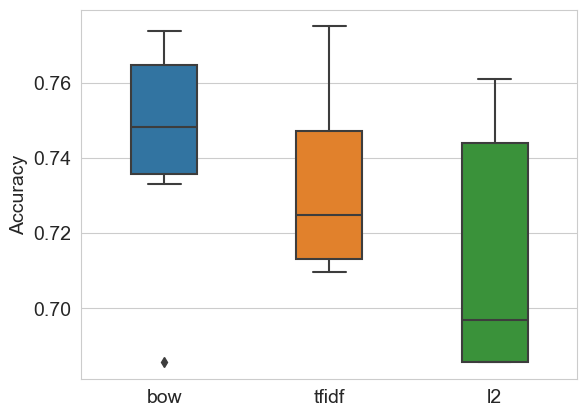

In [34]:
search_results = pd.DataFrame.from_dict({
    'bow': bow_search.cv_results_['mean_test_score'], 
    'tfidf': tfidf_search.cv_results_['mean_test_score'], 
    'l2': l2_search.cv_results_['mean_test_score']})

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)

### Final training and testing step to compare the different feature sets

In [37]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.7806421895662768
Test score with l2-normalized features: 0.7778933448239996
Test score with tf-idf features: 0.7813999791979317
